# Homework 2: A* Search Algorithm and Heuristics

This homework explores the A* search algorithm with different heuristics in two real-world scenarios:
1. **City Grid Route Planning** - Delivery robot navigation with different heuristics
2. **Flight Route Optimization** - International flight booking with geographic heuristics

**Learning Objectives:**
- Understand how different heuristics affect A* performance
- Compare admissible vs inadmissible heuristics
- Analyze trade-offs between optimality and search efficiency
- Apply A* to real-world pathfinding problems

## Exercise 1: City Grid Route Planning (A* with Different Heuristics)

**Real-World Scenario:** A delivery robot must navigate from a warehouse to a customer location across a city grid. Some streets are blocked due to construction, and the robot can move in 8 directions (including diagonals). We want to find the optimal route while minimizing the number of cells explored.

**Problem:** Implement A* search with multiple heuristics and compare their performance:
1. **Manhattan distance** (admissible for 4-directional movement)
2. **Euclidean distance** (admissible for any movement)
3. **Octile/Diagonal distance** (admissible for 8-directional movement)
4. **Inadmissible heuristic** (1.5 × Diagonal distance)

**Your Task:** Complete the A* implementation and heuristic functions. Compare how each heuristic affects:
- Path cost (optimality)
- Number of nodes expanded (efficiency)
- Search behavior (visualization)

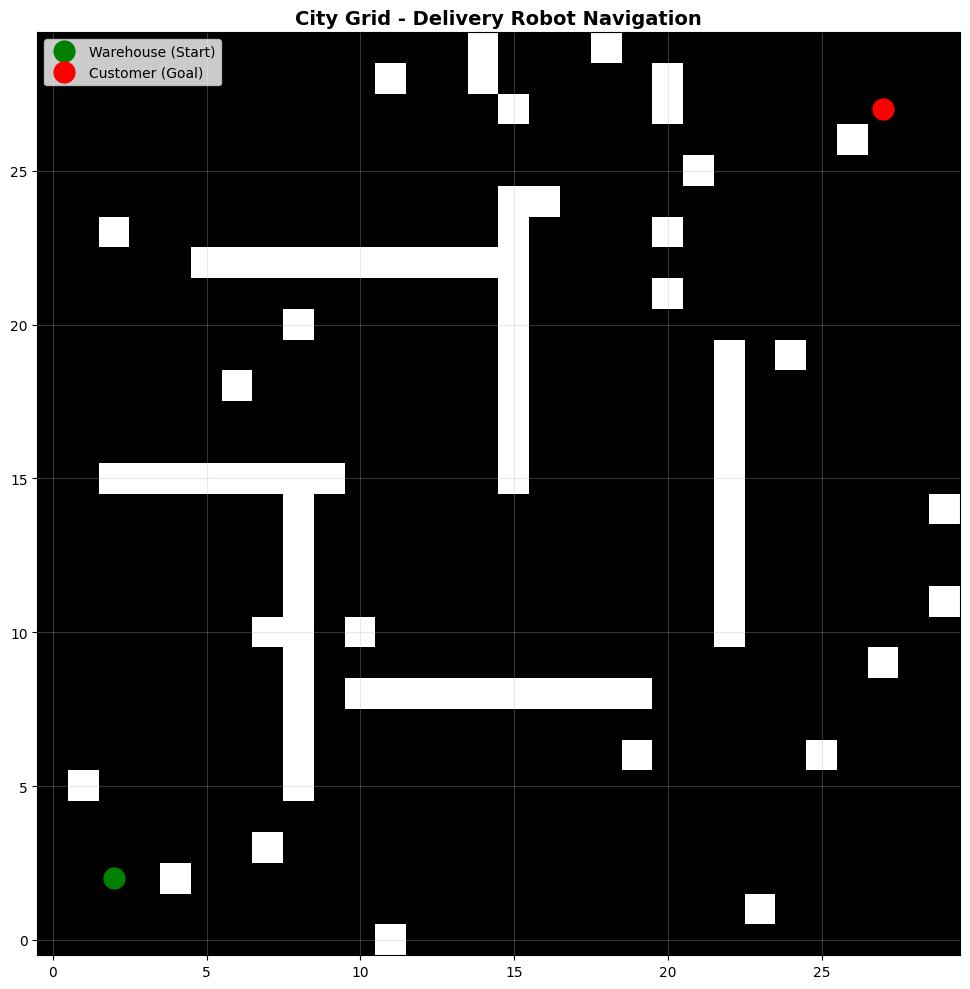

Optimal cost (UCS): 40.042

Heuristic comparison:
- UCS (h=0)            | cost =  40.042 | expanded =   802 | optimal? True
- Manhattan            | cost =  43.556 | expanded =    74 | optimal? False
- Euclidean            | cost =  40.042 | expanded =   263 | optimal? True
- Diagonal             | cost =  40.042 | expanded =   166 | optimal? True
- Inadmissible x1.5    | cost =  42.042 | expanded =    92 | optimal? False

Generating visualizations...


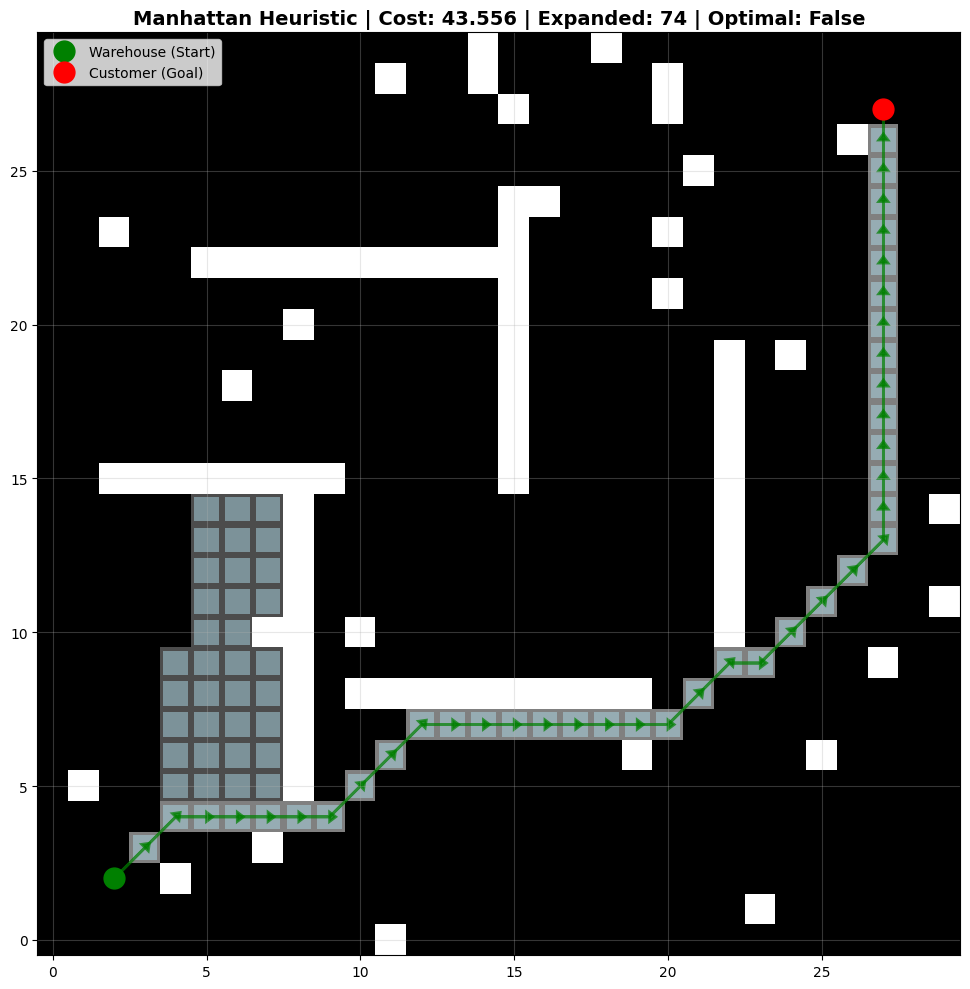

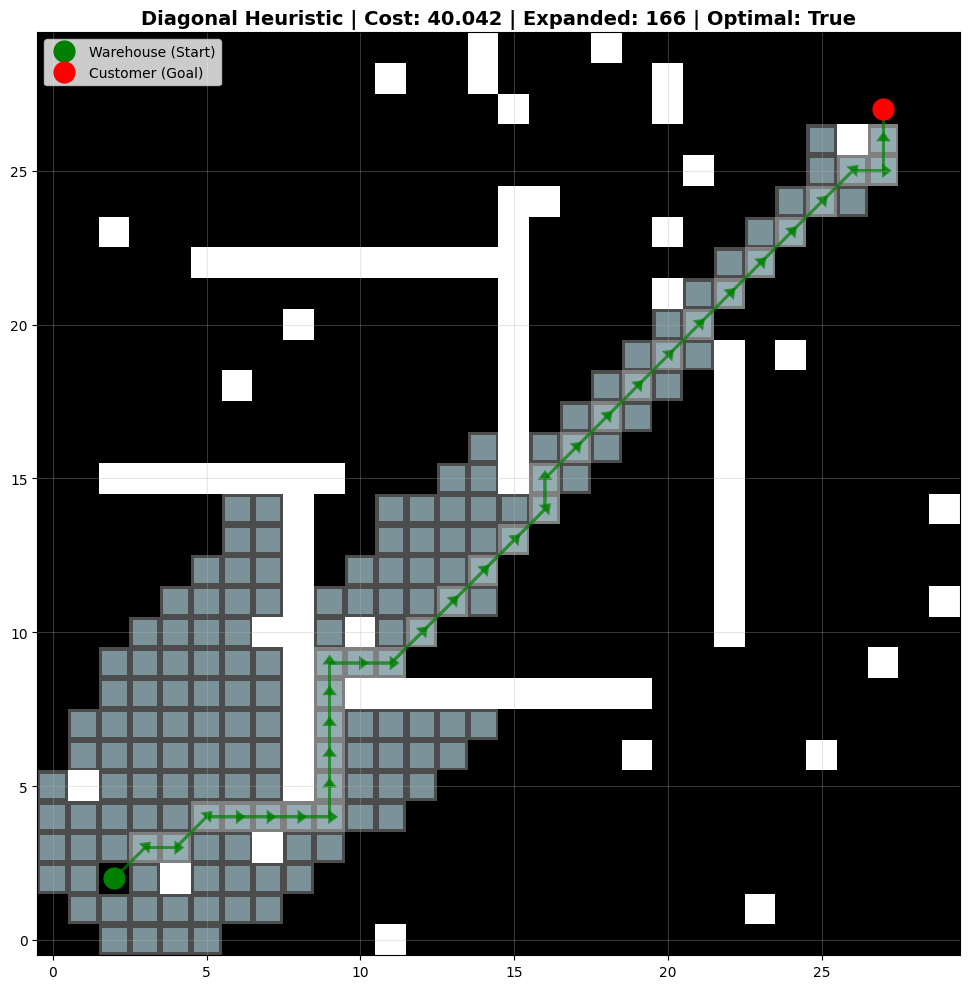

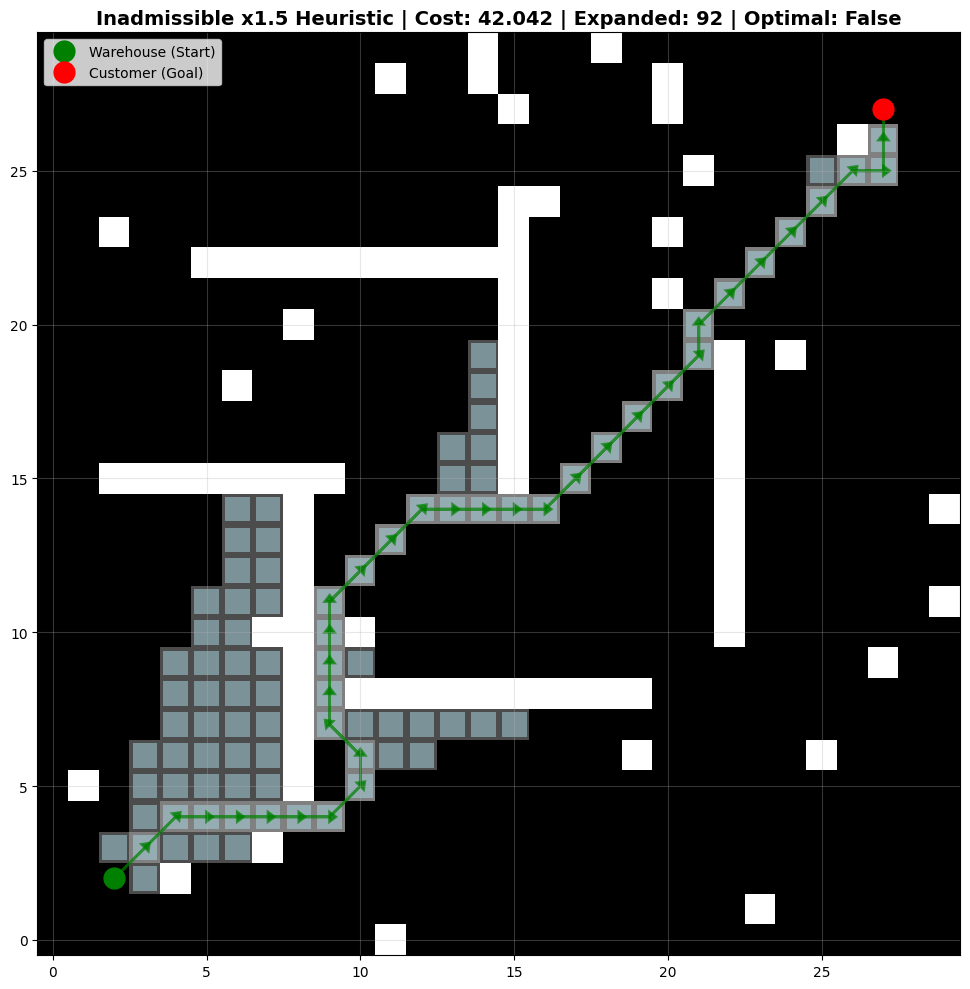

In [4]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import heapq
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

# Create a city grid (0 = open, 1 = blocked)
np.random.seed(42)
grid_size = 30
city_grid = np.zeros((grid_size, grid_size))

# Add some blocked streets (obstacles)
# Vertical barriers
city_grid[5:15, 8] = 1
city_grid[15:25, 15] = 1
city_grid[10:20, 22] = 1

# Horizontal barriers
city_grid[8, 10:20] = 1
city_grid[15, 2:10] = 1
city_grid[22, 5:15] = 1

# Random obstacles
for _ in range(30):
    x, y = np.random.randint(0, grid_size, 2)
    if (x, y) != (2, 2) and (x, y) != (27, 27):  # Keep start and end clear
        city_grid[x, y] = 1

start = (2, 2)
goal = (27, 27)

# Visualize the city grid
def visualize_grid(grid, start, goal, path=None, expanded=None, title="City Grid"):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create color map
    display_grid = grid.copy()
    
    # Show expanded nodes in light blue
    if expanded:
        for node in expanded:
            if node != start and node != goal:
                display_grid[node] = 0.3
    
    # Show path in green
    if path:
        for node in path:
            if node != start and node != goal:
                display_grid[node] = 0.5
    
    cmap = ListedColormap(['white', 'black', 'lightblue', 'lightgreen'])
    ax.imshow(display_grid, cmap='gray', origin='lower')
    
    # Highlight expanded nodes
    if expanded:
        for node in expanded:
            if node != start and node != goal:
                ax.add_patch(Rectangle((node[1]-0.4, node[0]-0.4), 0.8, 0.8, 
                                      fill=True, facecolor='lightblue', alpha=0.5))
    
    # Highlight path
    if path:
        for i in range(len(path)-1):
            y1, x1 = path[i]
            y2, x2 = path[i+1]
            ax.arrow(x1, y1, x2-x1, y2-y1, head_width=0.3, head_length=0.2, 
                    fc='green', ec='green', linewidth=2, alpha=0.7)
    
    # Mark start and goal
    ax.plot(start[1], start[0], 'go', markersize=15, label='Warehouse (Start)')
    ax.plot(goal[1], goal[0], 'ro', markersize=15, label='Customer (Goal)')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_grid(city_grid, start, goal, title="City Grid - Delivery Robot Navigation")

# Heuristic functions
def h_manhattan(pos, goal):
    """
    Manhattan distance heuristic.
    Admissible for 4-directional movement (cost=1 per step).
    """
    # TODO: Implement Manhattan distance

    return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])

def h_euclidean(pos, goal):
    """
    Euclidean distance heuristic.
    Admissible for any movement pattern.
    """
    # TODO: Implement Euclidean distance
    return np.sqrt((pos[0] - goal[0])**2 + (pos[1]-goal[1])**2)

def h_diagonal(pos, goal):
    """
    Octile/Diagonal distance heuristic.
    Admissible for 8-directional movement with diagonal cost = sqrt(2).
    Formula: D * (dx + dy) + (D2 - 2*D) * min(dx, dy)
    where D = 1 (orthogonal cost), D2 = sqrt(2) (diagonal cost)
    """
    # TODO: Implement diagonal/octile distance
    D=1
    D2=m.sqrt(2)

    dy = abs(pos[0] - goal[0])
    dx = abs(pos[1] - goal[1])
    return D*(dx+dy)+(D2 -2*D) * min(dx, dy)

def h_inadmissible(pos, goal):
    """
    Inadmissible heuristic: 1.5 times the diagonal distance.
    This overestimates the true cost, making it inadmissible.
    """
    # TODO: Implement inadmissible heuristic (1.5 * diagonal distance)
    return 1.5*h_diagonal(pos, goal)

def h_zero(pos, goal):
    """Zero heuristic - equivalent to Uniform Cost Search."""
    return 0.0

def is_valid_position(pos, grid, parent_pos=None):
    x, y=pos
    row, cols = grid.shape
    if not (0 <= x < row and 0 <= y < cols):
        return False

    if grid[x,y] == 1:
        return False

    if parent_pos is not None:
        px, py = parent_pos
        dx = x - px
        dy = y - py

        if dx!=0 and dy!=0:
            if grid [px+dx, py] ==1 or grid [px, py+dy] == 1:
                return False

    return True

def get_neighbors_8dir(pos, grid):
    """
    Get valid neighbors in 8 directions (including diagonals).
    Returns list of (neighbor_pos, cost) tuples.
    """
    # TODO: Implement 8-directional neighbor generation
    # Hint: Include 4 orthogonal moves (cost=1.0) and 4 diagonal moves (cost=sqrt(2))
    x,y = pos
    neighbors = []
    
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nx, ny = x + dx, y + dy
        if is_valid_position((nx, ny),grid):
            neighbors.append(((nx, ny), 1.0))

    for dx, dy in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
        nx, ny = x + dx, y + dy
        if is_valid_position((nx, ny), grid, parent_pos=(x,y)):
            neighbors.append(((nx, ny), np.sqrt(2)))

    return neighbors

def astar_grid(grid, start, goal, heuristic):
    """
    A* algorithm for grid-based pathfinding.
    
    Args:
        grid: 2D numpy array (0=open, 1=blocked)
        start: tuple (y, x) starting position
        goal: tuple (y, x) goal position
        heuristic: function(pos, goal) -> estimated cost to goal
    
    Returns:
        path: list of positions from start to goal
        cost: total path cost
        expanded: set of expanded nodes
    """
    # Priority queue: (f_score, counter, position)
    counter = 0  # Tie-breaker for nodes with same f_score
    frontier = [(heuristic(start, goal), counter, start)]
    
    # Cost from start to node
    g_score = {start: 0}
    
    # Parent tracking for path reconstruction
    parent = {start: None}
    
    # Track expanded nodes
    expanded = set()

    closed_set =set()
    
    while frontier:
        f, _, current = heapq.heappop(frontier)
    # TODO: Implement A* algorithm
    # Hints:
    # - Use a priority queue (heapq) with f_score = g_score + h_score
    # - Track g_score (cost from start) for each node
    # - Track parent pointers for path reconstruction
    # - Track expanded nodes for visualization
        # Goal check
    # Your implementation here

        if current in closed_set:
            continue

        expanded.add(current)
        closed_set.add(current)

        if current == goal:
            path = []
            node = current
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return path, g_score[current], expanded

        for neighbor, move_cost in get_neighbors_8dir(current, grid):
            
            if neighbor in closed_set:
                continue

            tentative_g = g_score[current]+ move_cost

            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                parent[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score = tentative_g+heuristic(neighbor, goal)

                counter += 1
                heapq.heappush(frontier, (f_score, counter, neighbor))

    return None, float('inf'), set()

# Test A* with different heuristics
heuristics = [
    ("UCS (h=0)", h_zero),
    ("Manhattan", h_manhattan),
    ("Euclidean", h_euclidean),
    ("Diagonal", h_diagonal),
    ("Inadmissible x1.5", h_inadmissible)
]

# First, find optimal cost using UCS
optimal_path, optimal_cost, _ = astar_grid(city_grid, start, goal, h_zero)
print(f"Optimal cost (UCS): {optimal_cost:.3f}\n")

print("Heuristic comparison:")
results = []

for name, h_func in heuristics:
    path, cost, expanded = astar_grid(city_grid, start, goal, h_func)
    is_optimal = abs(cost - optimal_cost) < 0.001
    results.append((name, path, cost, len(expanded), is_optimal, expanded))
    print(f"- {name:20} | cost = {cost:7.3f} | expanded = {len(expanded):5d} | optimal? {is_optimal}")

# Visualize results for selected heuristics
print("\nGenerating visualizations...")

for name, path, cost, num_expanded, is_optimal, expanded in results:
    if name in ["Manhattan", "Diagonal", "Inadmissible x1.5"]:
        title = f"{name} Heuristic | Cost: {cost:.3f} | Expanded: {num_expanded} | Optimal: {is_optimal}"
        visualize_grid(city_grid, start, goal, path, expanded, title)

### Analysis: Why the Inadmissible Heuristic Can Be Faster

**Admissibility and Optimality:**
- An **admissible heuristic** never overestimates the true cost to the goal
- A* with an admissible heuristic is guaranteed to find the optimal path
- If h(n) ≤ true_cost(n, goal) for all nodes n, then h is admissible

**Why Inadmissible Heuristics Are Faster:**
1. **Overestimation bias**: By multiplying by 1.5, we overestimate distances, making the heuristic "more optimistic" about paths leading toward the goal
2. **Focused search**: The inflated heuristic strongly biases the search toward the goal, expanding fewer nodes
3. **Risk of suboptimality**: The search may prune promising paths early, potentially missing the optimal solution

**Trade-off:**
- **Admissible heuristics**: Guarantee optimal solution, but may explore more nodes
- **Inadmissible heuristics**: Can be much faster (expand fewer nodes), but may return suboptimal solutions

**When to use inadmissible heuristics:**
- When speed is critical and near-optimal solutions are acceptable
- In real-time systems (video games, robotics) where quick responses matter
- When the cost of computation exceeds the cost of suboptimality

## Exercise 2: International Flight Route Optimization

**Real-World Scenario:** You're building a flight booking system that finds the fastest route between European cities. Flights have different durations, and you want to minimize total travel time. Unlike grid-based problems, we'll use geographic distances as heuristics.

**Problem:** Implement A* for a flight network where:
- Nodes are cities (with latitude/longitude)
- Edges are flights (with actual flight times in minutes)
- Heuristic is based on geographic distance

**Heuristics to compare:**
1. **Admissible**: Haversine distance ÷ 950 km/h (maximum commercial jet speed)
2. **Aggressive**: Haversine distance ÷ 500 km/h (overestimates time, inadmissible)

**Your Task:** Complete the A* implementation for the flight network and analyze how geographic heuristics affect the search.

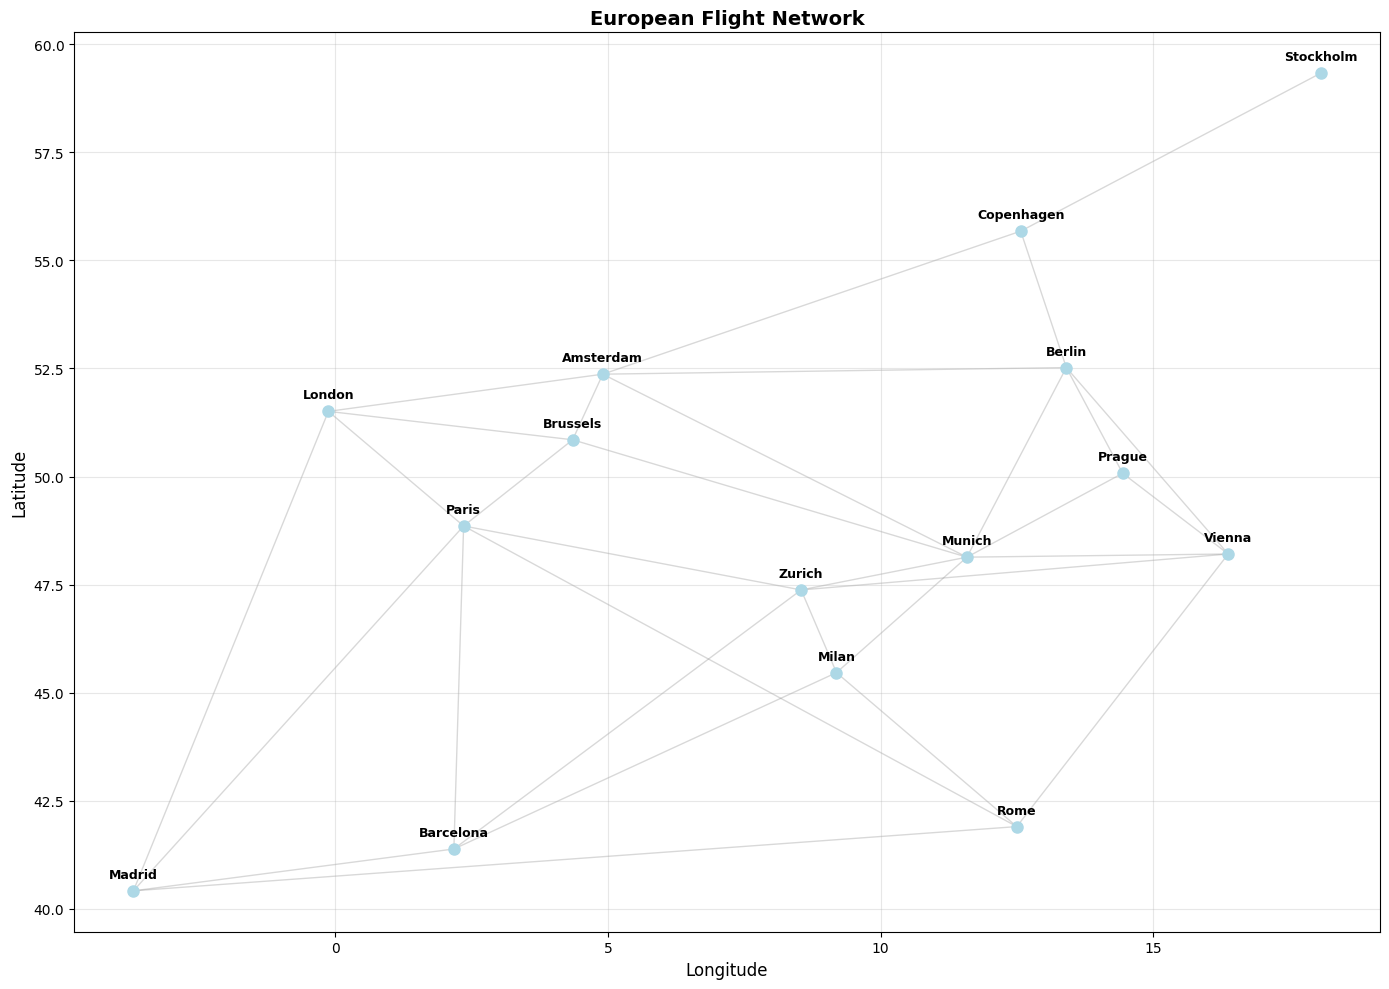


Flight Route Optimization Results:

UCS (h=0)              | Milan → London | time = 225 min | expanded =  14 | route = Milan → Munich → Brussels → London
Haversine/950 (adm.)   | Milan → London | time = 225 min | expanded =  12 | route = Milan → Munich → Brussels → London


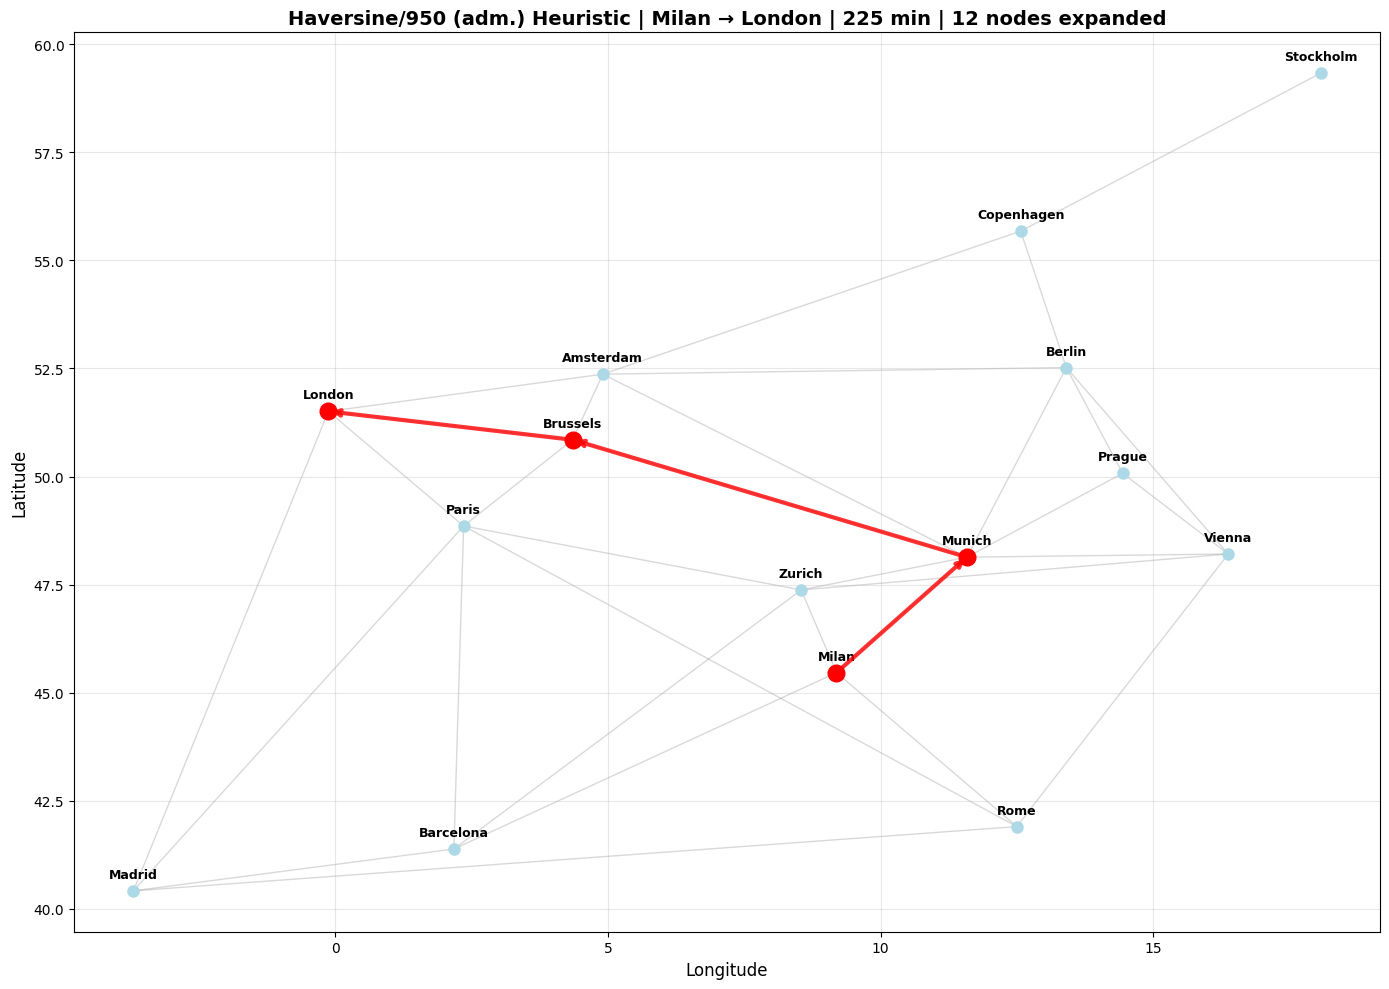

Haversine/500 (agg.)   | Milan → London | time = 225 min | expanded =   7 | route = Milan → Munich → Brussels → London


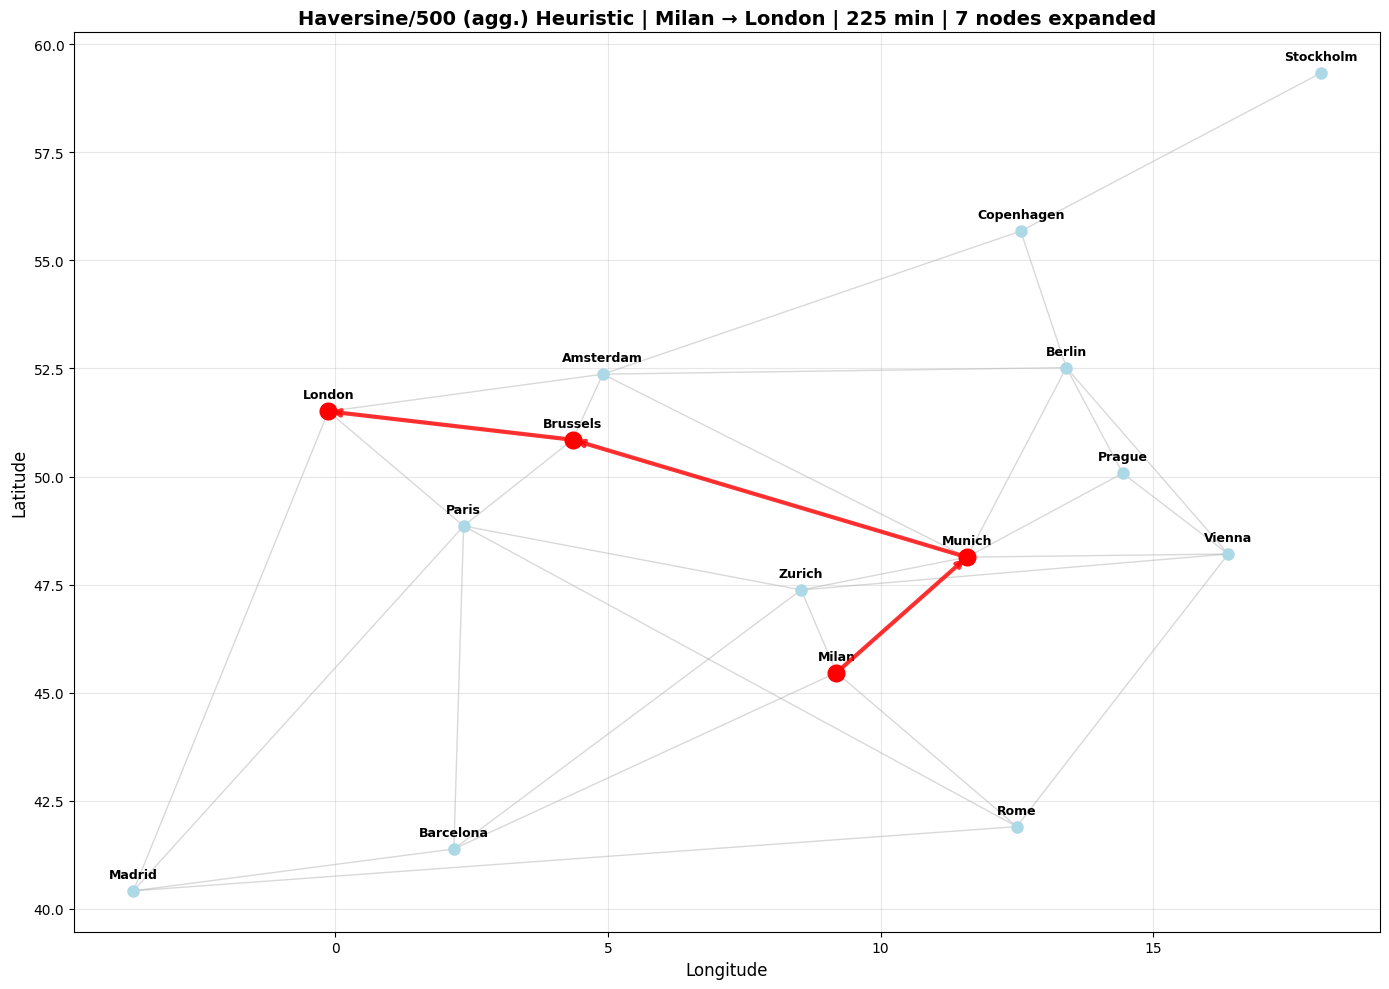


Testing another route: Stockholm → Barcelona

UCS (h=0)              | Stockholm → Barcelona | time = 370 min | expanded =  14 | route = Stockholm → Copenhagen → Amsterdam → Brussels → Paris → Barcelona
Haversine/950 (adm.)   | Stockholm → Barcelona | time = 370 min | expanded =  13 | route = Stockholm → Copenhagen → Amsterdam → Brussels → Paris → Barcelona
Haversine/500 (agg.)   | Stockholm → Barcelona | time = 370 min | expanded =   9 | route = Stockholm → Copenhagen → Amsterdam → Brussels → Paris → Barcelona


In [5]:
import math
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch

# City coordinates (latitude, longitude)
cities = {
    "London": (51.5074, -0.1278),
    "Paris": (48.8566, 2.3522),
    "Berlin": (52.5200, 13.4050),
    "Madrid": (40.4168, -3.7038),
    "Rome": (41.9028, 12.4964),
    "Amsterdam": (52.3676, 4.9041),
    "Vienna": (48.2082, 16.3738),
    "Prague": (50.0755, 14.4378),
    "Copenhagen": (55.6761, 12.5683),
    "Stockholm": (59.3293, 18.0686),
    "Milan": (45.4642, 9.1900),
    "Barcelona": (41.3851, 2.1734),
    "Munich": (48.1351, 11.5820),
    "Zurich": (47.3769, 8.5417),
    "Brussels": (50.8503, 4.3517)
}

# Flight connections with actual flight times (in minutes)
# Format: (origin, destination, flight_time_minutes)
flights = [
    ("London", "Paris", 80),
    ("London", "Amsterdam", 75),
    ("London", "Brussels", 70),
    ("London", "Madrid", 150),
    ("Paris", "Brussels", 50),
    ("Paris", "Madrid", 130),
    ("Paris", "Barcelona", 110),
    ("Paris", "Rome", 135),
    ("Paris", "Zurich", 90),
    ("Berlin", "Amsterdam", 90),
    ("Berlin", "Prague", 70),
    ("Berlin", "Copenhagen", 75),
    ("Berlin", "Vienna", 90),
    ("Berlin", "Munich", 65),
    ("Madrid", "Barcelona", 80),
    ("Madrid", "Rome", 160),
    ("Rome", "Milan", 75),
    ("Rome", "Vienna", 110),
    ("Amsterdam", "Brussels", 45),
    ("Amsterdam", "Copenhagen", 95),
    ("Amsterdam", "Munich", 85),
    ("Vienna", "Prague", 70),
    ("Vienna", "Munich", 75),
    ("Vienna", "Zurich", 90),
    ("Prague", "Munich", 65),
    ("Copenhagen", "Stockholm", 70),
    ("Milan", "Zurich", 60),
    ("Milan", "Munich", 70),
    ("Barcelona", "Milan", 110),
    ("Barcelona", "Zurich", 115),
    ("Munich", "Zurich", 60),
    ("Brussels", "Munich", 85)
]

# Build flight network graph
def build_flight_graph(flights):
    """Build bidirectional flight network."""
    G = {}
    for origin, dest, time in flights:
        # Bidirectional flights
        if origin not in G:
            G[origin] = {}
        if dest not in G:
            G[dest] = {}
        G[origin][dest] = time
        G[dest][origin] = time
    return G

flight_graph = build_flight_graph(flights)

# Haversine distance calculation
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on Earth.
    Returns distance in kilometers.
    """
    R = 6371  # Earth's radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    return R * c

# Heuristic functions for flight routing
def h_zero(city, goal, cities):
    """Zero heuristic - equivalent to Uniform Cost Search."""
    return 0.0

def h_admissible(city, goal, cities):
    """
    Admissible heuristic: Haversine distance / max_speed
    Uses 950 km/h (maximum commercial jet speed) to convert distance to time.
    This never overestimates since it assumes maximum possible speed.
    """
    # TODO: Implement admissible heuristic
    lat1, lon1= cities[city]
    lat2, lon2 = cities[goal]

    distance_km = haversine(lat1, lon1, lat2, lon2)

    max_speed = 950
    time_hours = distance_km / max_speed

    return time_hours * 60

def h_aggressive(city, goal, cities):
    """
    Aggressive (inadmissible) heuristic: Haversine distance / slower_speed
    Uses 500 km/h to overestimate time, making it inadmissible.
    This can lead to faster search but potentially suboptimal solutions.
    """
    # TODO: Implement aggressive heuristic
    lat1, lon1= cities[city]
    lat2, lon2 = cities[goal]

    distance_km = haversine(lat1, lon1, lat2, lon2)

    slower_speed = 500
    time_hours = distance_km / slower_speed

    return time_hours * 60

def astar_flights(source, target, heuristic):
    """
    A* algorithm for flight routing.
    
    Args:
        source: starting city
        target: destination city
        heuristic: function(city, goal, cities) -> estimated time to goal
    
    Returns:
        path: list of cities from source to target
        total_time: total flight time in minutes
        expanded: number of nodes expanded
    """
    # TODO: Implement A* for flight routing
    import heapq
    
    G = flight_graph
    frontier = [(heuristic(source, target, cities), source)]
    g = {source: 0}
    parent = {source: None}
    expanded = 0

    closed_set = set()
    while frontier:
        f, u = heapq.heappop(frontier)
        if u in closed_set:
            continue

        expanded += 1
        closed_set.add(u)

        if u == target:
            path = []
            node  = u
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return path, g[u], expanded

        for neighbor, flight_time in G[u].items():
            if neighbor in closed_set:
                continue

            tentative_g = g[u] + flight_time

            if neighbor not in g or tentative_g < g[neighbor]:
                g[neighbor] = tentative_g
                parent[neighbor] = u
                f_score = tentative_g + heuristic(neighbor, target, cities)
                heapq.heappush(frontier, (f_score, neighbor))

    return None, float('inf'), 0

# Visualize the flight network
def visualize_flight_network(cities, flights, path=None, title="European Flight Network"):
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot all cities
    for city, (lat, lon) in cities.items():
        ax.plot(lon, lat, 'o', markersize=8, color='lightblue', zorder=2)
        ax.text(lon, lat + 0.3, city, fontsize=9, ha='center', fontweight='bold')
    
    # Plot all flights in gray
    for origin, dest, _ in flights:
        lat1, lon1 = cities[origin]
        lat2, lon2 = cities[dest]
        ax.plot([lon1, lon2], [lat1, lat2], 'gray', alpha=0.3, linewidth=1, zorder=1)
    
    # Highlight path if provided
    if path:
        for i in range(len(path) - 1):
            lat1, lon1 = cities[path[i]]
            lat2, lon2 = cities[path[i+1]]
            ax.annotate('', xy=(lon2, lat2), xytext=(lon1, lat1),
                       arrowprops=dict(arrowstyle='->', color='red', lw=3, alpha=0.8),
                       zorder=3)
        
        # Highlight cities in path
        for city in path:
            lat, lon = cities[city]
            ax.plot(lon, lat, 'o', markersize=12, color='red', zorder=4)
    
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Show the flight network
visualize_flight_network(cities, flights)

# Test different heuristics
print("\nFlight Route Optimization Results:\n")

source, target = "Milan", "London"

heuristics_flight = [
    ("UCS (h=0)", h_zero),
    ("Haversine/950 (adm.)", h_admissible),
    ("Haversine/500 (agg.)", h_aggressive)
]

for name, h in heuristics_flight:
    path, minutes, expanded = astar_flights(source, target, h)
    if path:
        route_str = ' → '.join(path)
        print(f"{name:22} | {source} → {target} | time = {minutes:.0f} min | "
              f"expanded = {expanded:3d} | route = {route_str}")
        
        # Visualize paths for admissible and aggressive heuristics
        if name != "UCS (h=0)":
            title = f"{name} Heuristic | {source} → {target} | {minutes:.0f} min | {expanded} nodes expanded"
            visualize_flight_network(cities, flights, path, title)
    else:
        print(f"{name:22} | NO ROUTE")

print("\n" + "="*80)
print("Testing another route: Stockholm → Barcelona")
print("="*80 + "\n")

source2, target2 = "Stockholm", "Barcelona"

for name, h in heuristics_flight:
    path, minutes, expanded = astar_flights(source2, target2, h)
    if path:
        route_str = ' → '.join(path)
        print(f"{name:22} | {source2} → {target2} | time = {minutes:.0f} min | "
              f"expanded = {expanded:3d} | route = {route_str}")

## Short Reflection Questions

Based on your experiments with both exercises, answer the following:

### 1. Admissibility and Consistency
- **Which heuristics in Exercise 1 were admissible? Why?**
  - Manhattan, Euclidean, and Diagonal are all admissible because they never overestimate the true cost
  - The inadmissible heuristic (1.5× Diagonal) can overestimate, making it inadmissible

- **Which heuristics were consistent (satisfied the triangle inequality)?**
  - All admissible heuristics that are also monotonic are consistent
  - Diagonal distance is consistent for 8-directional movement
  - Manhattan is consistent for 4-directional movement (but underestimates for 8-directional)

### 2. Speed vs. Optimality Trade-offs
- **Where did you observe the clearest trade-off between search speed and solution optimality?**
  - The inadmissible heuristic in Exercise 1 expanded far fewer nodes but sometimes found suboptimal paths
  - The aggressive heuristic in Exercise 2 was faster but risked missing better routes

- **When might you prefer a faster, potentially suboptimal solution?**
  - Real-time applications (video games, interactive systems)
  - When the cost difference between optimal and suboptimal is small
  - When computational resources are limited

### 3. Heuristic Design for Flight Routing
- **In Exercise 2, when would the Haversine-based time lower bound break admissibility?**
  - If we assume a speed faster than the maximum possible aircraft speed
  - If we don't account for minimum connection times or airport constraints
  - If flights don't follow great-circle routes (e.g., avoiding restricted airspace)
  - If we use distance/speed < actual minimum flight time on any route

- **What real-world factors could make our admissible heuristic inadmissible?**
  - Headwinds/tailwinds affecting actual flight speeds
  - Mandatory layover times not captured in edge weights
  - Flight routes that must avoid certain airspaces
  - Airport congestion and taxi times

### 4. Practical Insights
- **For a delivery robot in a warehouse, which heuristic would you recommend and why?**
  - Diagonal distance for 8-directional movement: admissible, efficient, and well-matched to the problem
  - Balances optimality guarantee with good search efficiency

- **For a flight booking website with millions of queries per day, what approach would you take?**
  - Consider using a slightly inadmissible heuristic for speed if near-optimal is acceptable
  - Pre-compute common routes
  - Use bidirectional A* for better performance
  - Cache results for popular city pairs